# Simulating the Golenetskii correlation with popsynth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler

/Users/fran/.virtualenvs/grb/lib/python3.7/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


## GRB population

In [2]:
# redshift distribution
r0_true = 1.
rise_true = 1.
decay_true = 4.0
peak_true = 1.5

# luminosity function
Lmin_true = 1e51
alpha_true = 1.5
r_max = 7.0


pop_gen = popsynth.populations.ParetoSFRPopulation(
    r0=r0_true,
    rise=rise_true,
    decay=decay_true,
    peak=peak_true,
    Lmin=Lmin_true,
    alpha=alpha_true,
    r_max=r_max,
)

In [3]:
pop_gen.display()

## Luminosity Function

<IPython.core.display.Math object>

,parameter,value
0,Lmin,1.000000e+51
1,alpha,1.500000e+00


## Spatial Function

<IPython.core.display.Math object>

,parameter,value
0,r0,1.0
1,rise,1.0
2,decay,4.0
3,peak,1.5
4,r_max,7.0


## Auxiliary samplers

In [4]:
class TDecaySampler(popsynth.AuxiliarySampler):
    
    sigma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1)
    
    def __init__(self):
        """
        samples the decay of the of the pulse
        """

        super(TDecaySampler, self).__init__(name="tdecay", observed=False)

    def true_sampler(self, size):

        t90 = 10 ** self._secondary_samplers["log_t90"].true_values
        trise = self._secondary_samplers["trise"].true_values

        self._true_values = (
            1.0 / 50.0 * (10 * t90 + trise + np.sqrt(trise) * np.sqrt(20 * t90 + trise))
        )


class DurationSampler(popsynth.AuxiliarySampler):

    sigma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1)
    
    def __init__(self):
        """
        samples how long the pulse lasts
        """

        super(DurationSampler, self).__init__(
            name="duration", observed=False
        )

    def true_sampler(self, size):

        t90 = 10 ** self._secondary_samplers["log_t90"].true_values

        self._true_values = 1.5 * t90
        
        
class EpeakSampler(popsynth.AuxiliarySampler):
    """
    Samples Epeak for a given L
    """
    
    Nrest = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1e52)
    gamma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1.5, vmin=0)
    s_scat = popsynth.auxiliary_sampler.AuxiliaryParameter(default=0.1)
    
    s_det = popsynth.auxiliary_sampler.AuxiliaryParameter(default=0.1)
    
    def __init__(self):
        
        super(EpeakSampler, self).__init__('Epeak', 
                                           observed=True, 
                                           uses_luminosity=True, 
                                           uses_distance=True)
        
    def true_sampler(self, size):
        
        index = (np.log10(self._luminosity) - np.log10(self.Nrest)) / self.gamma
        Ep = np.power(10, index) * 100 # keV
        
        s = np.random.normal(0, self.s_scat*Ep, size)

        self._true_values = Ep + s
        
    def observation_sampler(self, size):
        
        Ep_obs = self._true_values / (1 + self._distance)

        s = np.random.normal(0, self.s_det*self._true_values, size)
        
        self._obs_values = Ep_obs + s

In [5]:
trise = TruncatedNormalAuxSampler(name="trise", observed=False)
trise.lower=0.01
trise.upper=5.0
trise.mu=1
trise.tau=1.0

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

tdecay = TDecaySampler()
duration = DurationSampler()
tdecay.set_secondary_sampler(t90)
tdecay.set_secondary_sampler(trise)
duration.set_secondary_sampler(t90)

Epeak = EpeakSampler()

In [6]:
pop_gen.add_observed_quantity(tdecay)
pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(Epeak)

registering auxilary sampler: tdecay
registering auxilary sampler: duration
registering auxilary sampler: Epeak


## Survey

In [7]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2)

The volume integral is 38.111186



Expecting 32 total objects
Sampling: tdecay
tdecay is sampling its secondary quantities
Sampling: log_t90
Sampling: trise
Sampling: duration
duration is sampling its secondary quantities
Sampling: Epeak
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 32 objects or to a distance of 3.08


Text(0, 0.5, '$L$ (erg/s)')

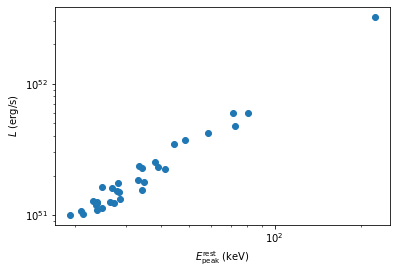

In [8]:
fig, ax = plt.subplots()

ax.scatter(population.Epeak, population.luminosities)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{rest}$ (keV)')
ax.set_ylabel('$L$ (erg/s)')

Text(0, 0.5, '$F_E$ (erg $\\mathrm{s}^{-1}$ $\\mathrm{cm}^{-2}$)')

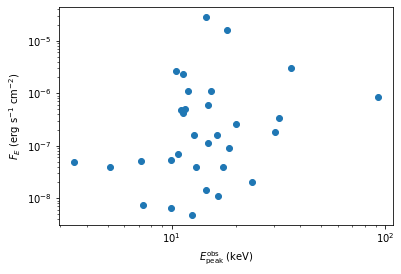

In [9]:
fig, ax = plt.subplots()
ax.scatter(population.Epeak_obs, population.flux_observed_all)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{obs}$ (keV)')
ax.set_ylabel('$F_E$ (erg $\mathrm{s}^{-1}$ $\mathrm{cm}^{-2}$)')

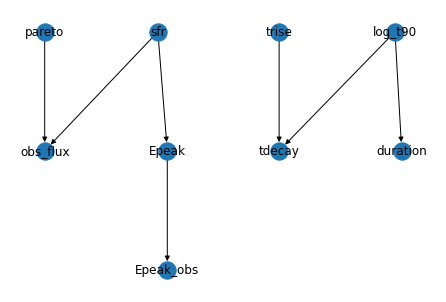

In [10]:
# Graph needs fixing for L-dependence
pos=nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog='dot')

nx.draw(pop_gen.graph, with_labels=True,pos=pos)